In [1]:
# Importación de librerías esenciales
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import csv
from PIL import Image
import io

# Lista para guardar imágenes del entrenamiento
frames = []

# =====================================================
# SOLUCIÓN EXACTA DEL OSCILADOR ARMÓNICO AMORTIGUADO
# =====================================================
def exact_solution(d, w0, t):
    assert d < w0
    w = np.sqrt(w0**2 - d**2)
    phi = np.arctan(-d / w)
    A = 1 / (2 * np.cos(phi))
    cos = torch.cos(phi + w * t)
    exp = torch.exp(-d * t)
    u = exp * 2 * A * cos
    return u

# =====================================================
# DEFINICIÓN DE LA RED NEURONAL TOTALMENTE CONECTADA
# =====================================================
class FCN(nn.Module):
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(nn.Linear(N_INPUT, N_HIDDEN), activation())
        self.fch = nn.Sequential(*[
            nn.Sequential(nn.Linear(N_HIDDEN, N_HIDDEN), activation())
            for _ in range(N_LAYERS - 1)
        ])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)

    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

# =====================================================
# ENTRENAMIENTO DEL MODELO PINN
# =====================================================
torch.manual_seed(123)

with open("training_metrics.csv", mode="w", newline="") as file:
    writer = csv.writer(file)
    writer.writerow(["Iteration", "Total_Loss", "Loss1", "Loss2", "Loss3", "MSE"])

pinn = FCN(1, 1, 8, 2)

t_boundary = torch.tensor(0.).view(-1, 1).requires_grad_(True)
t_physics = torch.linspace(0, 1, 30).view(-1, 1).requires_grad_(True)

d, w0 = 2, 20
mu, k = 2 * d, w0 ** 2

t_test = torch.linspace(0, 1, 300).view(-1, 1)
u_exact = exact_solution(d, w0, t_test)

optimiser = torch.optim.Adam(pinn.parameters(), lr=1e-3)

for i in range(10001):
    optimiser.zero_grad()

    lambda1, lambda2 = 1e-1, 1e-4

    # Condiciones iniciales
    u_b = pinn(t_boundary)
    loss1 = (torch.squeeze(u_b) - 1) ** 2
    dudt_b = torch.autograd.grad(u_b, t_boundary, torch.ones_like(u_b), create_graph=True)[0]
    loss2 = (torch.squeeze(dudt_b) - 0) ** 2

    # Física
    u_p = pinn(t_physics)
    dudt = torch.autograd.grad(u_p, t_physics, torch.ones_like(u_p), create_graph=True)[0]
    d2udt2 = torch.autograd.grad(dudt, t_physics, torch.ones_like(dudt), create_graph=True)[0]
    loss3 = torch.mean((d2udt2 + mu * dudt + k * u_p) ** 2)

    loss = loss1 + lambda1 * loss2 + lambda2 * loss3
    loss.backward()
    optimiser.step()

    u_pred = pinn(t_test).detach()
    mse = torch.mean((u_pred - u_exact) ** 2).item()

    if i % 100 == 0:
        with open("training_metrics.csv", mode="a", newline="") as file:
            writer = csv.writer(file)
            writer.writerow([i, loss.item(), loss1.item(), loss2.item(), loss3.item(), mse])

        print(f"[{i:5d}] Loss: {loss.item():.4e} | "
              f"Loss1 (u(0)-1)^2: {loss1.item():.2e} | "
              f"Loss2 (u'(0))^2: {loss2.item():.2e} | "
              f"Loss3 (PDE): {loss3.item():.2e} | "
              f"MSE vs exact: {mse:.2e}")

        # Gráfica y captura de imagen
        fig, ax = plt.subplots(figsize=(6, 2.5))
        ax.scatter(t_physics.detach()[:, 0], torch.zeros_like(t_physics)[:, 0],
                   s=20, lw=0, color="tab:green", alpha=0.6, label="Physics points")
        ax.scatter(t_boundary.detach()[:, 0], torch.zeros_like(t_boundary)[:, 0],
                   s=20, lw=0, color="tab:red", alpha=0.6, label="Boundary point")
        ax.plot(t_test[:, 0], u_exact[:, 0], label="Exact solution", color="tab:grey", alpha=0.6)
        ax.plot(t_test[:, 0], u_pred[:, 0], label="PINN solution", color="tab:green")
        ax.set_title(f"Step {i}")
        ax.legend()
        plt.tight_layout()

        buf = io.BytesIO()
        plt.savefig(buf, format='png')
        buf.seek(0)
        frames.append(Image.open(buf))
        plt.close()

# Guardar GIF
frames[0].save("pinn_training.gif", format='GIF',
               append_images=frames[1:], save_all=True,
               duration=120, loop=0)

[    0] Loss: 2.6888e+00 | Loss1 (u(0)-1)^2: 4.35e-01 | Loss2 (u'(0))^2: 2.74e-03 | Loss3 (PDE): 2.25e+04 | MSE vs exact: 2.50e-01
[  100] Loss: 8.2271e-01 | Loss1 (u(0)-1)^2: 7.49e-01 | Loss2 (u'(0))^2: 5.42e-02 | Loss3 (PDE): 6.87e+02 | MSE vs exact: 1.29e-01
[  200] Loss: 7.8464e-01 | Loss1 (u(0)-1)^2: 6.40e-01 | Loss2 (u'(0))^2: 1.50e-01 | Loss3 (PDE): 1.29e+03 | MSE vs exact: 1.31e-01
[  300] Loss: 7.8047e-01 | Loss1 (u(0)-1)^2: 6.22e-01 | Loss2 (u'(0))^2: 1.85e-01 | Loss3 (PDE): 1.40e+03 | MSE vs exact: 1.32e-01
[  400] Loss: 7.7633e-01 | Loss1 (u(0)-1)^2: 6.15e-01 | Loss2 (u'(0))^2: 2.11e-01 | Loss3 (PDE): 1.40e+03 | MSE vs exact: 1.31e-01
[  500] Loss: 7.7200e-01 | Loss1 (u(0)-1)^2: 6.08e-01 | Loss2 (u'(0))^2: 2.44e-01 | Loss3 (PDE): 1.39e+03 | MSE vs exact: 1.31e-01
[  600] Loss: 7.6769e-01 | Loss1 (u(0)-1)^2: 6.01e-01 | Loss2 (u'(0))^2: 2.81e-01 | Loss3 (PDE): 1.38e+03 | MSE vs exact: 1.30e-01
[  700] Loss: 7.6355e-01 | Loss1 (u(0)-1)^2: 5.94e-01 | Loss2 (u'(0))^2: 3.24e-01 |

In [28]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import csv
from PIL import Image
import io

# Lista para guardar imágenes del entrenamiento
frames = []

# ============================================
# SOLUCIÓN EXACTA DEL OSCILADOR AMORTIGUADO
# ============================================
def exact_solution(d, w0, t):
    assert d < w0
    w = np.sqrt(w0**2 - d**2)
    phi = np.arctan(-d / w)
    A = 1 / (2 * np.cos(phi))
    cos = torch.cos(phi + w * t)
    exp = torch.exp(-d * t)
    u = exp * 2 * A * cos
    return u

# ============================================
# DEFINICIÓN DE LA RED NEURONAL TOTALMENTE CONECTADA
# ============================================
class FCN(nn.Module):
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(nn.Linear(N_INPUT, N_HIDDEN), activation())
        self.fch = nn.Sequential(*[
            nn.Sequential(nn.Linear(N_HIDDEN, N_HIDDEN), activation())
            for _ in range(N_LAYERS - 1)
        ])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)

    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

# ============================================
# PARÁMETROS DEL SISTEMA Y DATOS DE ENTRENAMIENTO
# ============================================
torch.manual_seed(123)
d, w0 = 2, 20

# Datos sintéticos para entrenamiento (supervisado)
t_train = torch.linspace(0, 1, 30).view(-1, 1)  # mismos puntos que t_physics antes
u_train = exact_solution(d, w0, t_train)

# Datos para evaluación
t_test = torch.linspace(0, 1, 300).view(-1, 1)
u_exact = exact_solution(d, w0, t_test)

# ============================================
# INICIALIZACIÓN DE MODELO Y OPTIMIZADOR
# ============================================
pinn = FCN(1, 1, 20, 3)
optimiser = torch.optim.Adam(pinn.parameters(), lr=1e-3)

# ============================================
# ARCHIVO PARA GUARDAR MÉTRICAS
# ============================================
with open("training_metrics.csv", mode="w", newline="") as file:
    writer = csv.writer(file)
    writer.writerow(["Iteration", "Loss", "MSE"])

# ============================================
# BUCLE DE ENTRENAMIENTO SUPERVISADO DIRECTO
# ============================================
for i in range(10001):
    optimiser.zero_grad()

    u_pred = pinn(t_train)
    loss = torch.mean((u_pred - u_train) ** 2)

    loss.backward()
    optimiser.step()

    # Evaluación en test
    u_pred_test = pinn(t_test).detach()
    mse = torch.mean((u_pred_test - u_exact) ** 2).item()

    if i % 100 == 0:
        with open("training_metrics.csv", mode="a", newline="") as file:
            writer = csv.writer(file)
            writer.writerow([i, loss.item(), mse])

        print(f"[{i:5d}] Loss (train): {loss.item():.4e} | MSE (test): {mse:.4e}")

        # Gráfica y captura de imagen
        fig, ax = plt.subplots(figsize=(6, 2.5))
        ax.scatter(t_train[:, 0], u_train[:, 0],
                   s=20, lw=0, color="tab:blue", alpha=0.6, label="Training data")
        ax.plot(t_test[:, 0], u_exact[:, 0], label="Exact solution", color="tab:grey", alpha=0.6)
        ax.plot(t_test[:, 0], u_pred_test[:, 0], label="NN prediction", color="tab:green")
        ax.set_title(f"Step {i}")
        ax.legend()
        plt.tight_layout()

        buf = io.BytesIO()
        plt.savefig(buf, format='png')
        buf.seek(0)
        frames.append(Image.open(buf))
        plt.close()

# Guardar GIF
frames[0].save("nn_training.gif", format='GIF',
               append_images=frames[1:], save_all=True,
               duration=120, loop=0)


[    0] Loss (train): 1.4892e-01 | MSE (test): 1.3522e-01
[  100] Loss (train): 1.3530e-01 | MSE (test): 1.2768e-01
[  200] Loss (train): 1.2793e-01 | MSE (test): 1.2319e-01
[  300] Loss (train): 9.1229e-02 | MSE (test): 9.1559e-02
[  400] Loss (train): 3.7796e-02 | MSE (test): 3.7955e-02
[  500] Loss (train): 2.5178e-02 | MSE (test): 2.5665e-02
[  600] Loss (train): 1.5872e-02 | MSE (test): 1.6518e-02
[  700] Loss (train): 1.0740e-02 | MSE (test): 1.0849e-02
[  800] Loss (train): 6.0601e-03 | MSE (test): 6.0233e-03
[  900] Loss (train): 3.7521e-03 | MSE (test): 3.4570e-03
[ 1000] Loss (train): 3.1925e-03 | MSE (test): 2.7110e-03
[ 1100] Loss (train): 3.0286e-03 | MSE (test): 2.5005e-03
[ 1200] Loss (train): 2.9198e-03 | MSE (test): 2.3905e-03
[ 1300] Loss (train): 2.8206e-03 | MSE (test): 2.3309e-03
[ 1400] Loss (train): 2.7337e-03 | MSE (test): 2.2696e-03
[ 1500] Loss (train): 2.6757e-03 | MSE (test): 2.2111e-03
[ 1600] Loss (train): 2.5789e-03 | MSE (test): 2.1629e-03
[ 1700] Loss (

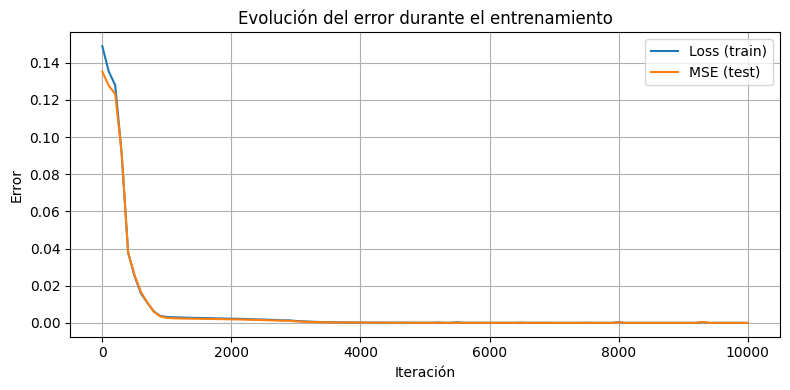

In [31]:
import matplotlib.pyplot as plt
import csv

# Listas para almacenar los datos
iterations = []
losses = []
mses = []

# Leer el archivo CSV
with open("training_metrics.csv", mode="r") as file:
    reader = csv.DictReader(file)
    for row in reader:
        iterations.append(int(row["Iteration"]))
        losses.append(float(row["Loss"]))
        mses.append(float(row["MSE"]))

# Crear la figura
plt.figure(figsize=(8, 4))

# Graficar el Loss y el MSE
plt.plot(iterations, losses, label="Loss (train)", color="tab:blue")
plt.plot(iterations, mses, label="MSE (test)", color="tab:orange")
plt.xlabel("Iteración")
plt.ylabel("Error")
plt.title("Evolución del error durante el entrenamiento")
plt.legend()
plt.grid(True)
plt.tight_layout()

# Mostrar o guardar la gráfica
plt.savefig("training_error_plot.png")
plt.show()

In [27]:
import torch
import torch.nn as nn

# Red definida como en tu código
class FCN(nn.Module):
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(nn.Linear(N_INPUT, N_HIDDEN), activation())
        self.fch = nn.Sequential(*[
            nn.Sequential(nn.Linear(N_HIDDEN, N_HIDDEN), activation())
            for _ in range(N_LAYERS - 1)
        ])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)

    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

# Instancia del modelo
model = FCN(1, 1, 30, 2)

# Cálculo del número de parámetros
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total de parámetros: {total_params}")
print(f"Parámetros entrenables: {trainable_params}")


Total de parámetros: 1021
Parámetros entrenables: 1021
